In [1]:
%config IPCompleter.greedy=True    #intellisense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
rvp=pd.read_csv('../mzoom/data/Copy of rvp_30days_data.csv',encoding = "ISO-8859-1", low_memory=False)
# print("RVP columns: ", rvp.columns)

In [3]:
df=pd.DataFrame(rvp)
total_rows = float(len(df.index))

In [4]:
df['ret_amnt_bucket']=df['return_amount'].apply(lambda x: '>2000' if x>2000 else '1000-2000' if x>1000 else '750-1000'  if x>750 else '299-750' if x>299 else '0-299' if x<=299 else np.nan)

In [5]:
df['return_item_request_date_time'] = pd.to_datetime(df['return_item_request_date_time']).dt.strftime('%m/%d/%Y')

In [6]:
df['order_item_max_delivery_date_time'] = pd.to_datetime(df['order_item_max_delivery_date_time']).dt.strftime('%m/%d/%Y')

In [7]:
# ## list of number rows unique value in each dimension
# column_uniques = pd.Series(len(pd.unique(df[c].values)) for c in df)

# # for i in range(len(df.dtypes)):
# #     print(df.dtypes.index[i],":\t", column_uniques[i])
# print("\nTotal Rows: ", total_rows)

In [8]:
# ## list of columns to be removed
# drop_dimensions=[]
# # drop_dimensions=['return_from_address_pincode','return_from_address_city','user_approved_by','return_amount','pincode']

# for c in column_uniques.index:
#     if(column_uniques[c]>total_rows/100): drop_dimensions.append(df.dtypes.index[c])

# print("Removing Dimensions: ", drop_dimensions)
# df = df.drop(columns=drop_dimensions)

In [9]:
# ## MZoom uses a txt reader, So we need to remove entries with comma in them
# columns_with_comma = ['brand','return_from_address_city'] # all dimensions that can contain string inputs

# for col in columns_with_comma:
#     if(col in df.columns):
#         df= df[~df[col].str.contains(',', na=False)]

# print("rows: ",len(df.index)," total: ", total_rows, ", columns: ",len(df.columns))

In [10]:
## Creating a Y (mass) value for tensor
df['mass']=df['return_item_quantity']

In [11]:
# column_uniques = pd.Series(len(pd.unique(df[c].values)) for c in df)
# for i in range(len(df.dtypes)):
#     print(df.dtypes.index[i],":\t", column_uniques[i])
# print("\nTotal Rows: ", total_rows)
# print("\nTotal columns: ", len(column_uniques))
# num_dimension = len(column_uniques)-1

In [12]:
# df.to_csv('../mzoom/data/rvp_complete_cleaned.csv', index=False, encoding="ISO-8859-1", header=False)

In [13]:
report_columns = ['analytic_vertical','is_alpha_seller','order_payment_type','order_sales_channel','refund_mode',
                  'ret_amnt_bucket','return_action','return_from_address_pincode','return_reason',
                  'return_request_channel','mass']
problem = pd.DataFrame(df,columns=report_columns)

In [58]:
## list of number rows unique value in each dimension
column_uniques = pd.Series(len(pd.unique(problem[c].values)) for c in problem)

for i in range(len(problem.dtypes)):
    print(problem.dtypes.index[i],":\t", column_uniques[i])
print("\nTotal Rows: ", total_rows)

analytic_vertical :	 2114
is_alpha_seller :	 3
order_payment_type :	 4
order_sales_channel :	 6
refund_mode :	 6
ret_amnt_bucket :	 6
return_action :	 10
return_from_address_pincode :	 18903
return_reason :	 27
return_request_channel :	 4
mass :	 1

Total Rows:  2670351.0


In [14]:
# problem

In [15]:
problem.to_csv('../mzoom/data/rvp_cleaned_problem.csv', index=False, encoding="ISO-8859-1", header=False)

In [75]:
rvp_report = pd.read_csv('../anamoly_detection_20190626.csv')
density_type='ari'
num_blocks = 5

In [17]:
dimensions = len(problem.columns)
dimensions

11

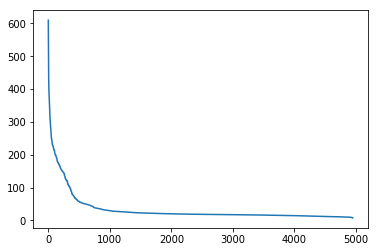

In [18]:
plt.plot(rvp_report['score'].tolist())

In [93]:
%%bash

## THIS DOESN"T WORK RIGHT AS - IT DOESN"T WRITE OUTPUTS
## ToDo - interactive inputs

cd ..
cd mzoom
DENSITY_TYPE='ari'
NUM_BLOCKS=5
LOWER_BOUND=1
UPPER_BOUND=100
./run_mzoom.sh data/rvp_cleaned_problem.csv data/output_rvp_problem_ari_5_1_100 10 $DENSITY_TYPE $NUM_BLOCKS $LOWER_BOUND $UPPER_BOUND > data/run.txt


In [94]:
mzoom_attributes = []
for i in range(1,num_blocks+1):
    mzoom_attributes.append(pd.read_csv('../mzoom/data/output_rvp_problem_'+density_type+'_'+str(num_blocks)+'_1_100/block_'+str(i)+'.attributes',header=None))
  

In [95]:
mz_attr = []
for sub_t in mzoom_attributes:
    mz_attr.append(sub_t.groupby([0]).aggregate(lambda x: x.unique().tolist()))

In [96]:
report_columns = ['analytic_vertical','is_alpha_seller','order_payment_type','order_sales_channel','refund_mode',
                  'ret_amnt_bucket','return_action','return_from_address_pincode','return_reason',
                  'return_request_channel']
report = pd.DataFrame(rvp_report, columns=report_columns)

mz_attr_df=[]
for st in mz_attr:
    d={}
    for c in report_columns:
        d[c] = [st[1][report.columns.get_loc(c)]]
    mz_attr_df.append(pd.DataFrame(d))

In [97]:
mz_attr_df[0]

,analytic_vertical,is_alpha_seller,order_payment_type,order_sales_channel,refund_mode,ret_amnt_bucket,return_action,return_from_address_pincode,return_reason,return_request_channel
0,"[MenCasualShoe, BluetoothHeadset, MensTrackPan...","[1.0, 0.0]","[Prepaid, COD]","[AndroidApp, iOSApp, WEB, MobileSite]","[NEFT, nan, back_to_source, QC_EGV]","[1000-2000, >2000, 750-1000, 299-750, 0-299]","[wait_refund, exchange_expect, replace_expect]","[560064.0, 226010.0, 560043.0, 401107.0, 56006...","[SIZE_FIT_ISSUES, CUSTOMER_REMORSE, DEFECTIVE_...","[CS_AGENT, SELF_SERVE]"


In [98]:
# contain_ratios = []

# for st in mz_attr_df:
#     block_contain={}
#     for c in report.columns:
#         uniques = pd.unique(report[c])
#         num_uniques = len(uniques)
#         count_contain = 0
#         for i in uniques:
#             if i in st[c][0]:
#                 count_contain+=1
#         block_contain[c] = count_contain/num_uniques
#     contain_ratios.append(block_contain)

# print(contain_ratios)
# for r in range(len(contain_ratios)):
#     print("Density Type: ", density_type, " Block: ", r+1)
#     plt.barh(*zip(*contain_ratios[r].items()))
#     plt.show()

In [99]:
/block_'+str(i)+'.attributes',header=None))
  # row_contain_ratio = []
# row_contain_weighted_ratio = []

# for st in mz_attr_df:
#     print("####### ###### ###### ###### ####### ####### ###### #######")
#     block_row_contain_ratio={}
#     block_row_contain_count=[]
#     #initialize every dictionay element to zero
#     for c in range(len(report.columns)+1):
#         block_row_contain_ratio[c] = 0
        
#     # for every row in report
#     for row in range(len(report.index)):
#         count_contain = 0
#         for i in report.columns:
#             if(pd.isna(report[i][row])):
#                 count_contain+=1
#             elif report[i][row] in st[i][0]:
#                 count_contain+=1
#             else:
#                 print(report[i][row])
#         block_row_contain_ratio[count_contain] += 1
#         block_row_contain_count.append(count_contain)
#     row_contain_ratio.append(block_row_contain_ratio)
#     row_contain_weighted_ratio.append(block_row_contain_count)

In [100]:
# row_contain_ratio

In [101]:
# for r in range(len(row_contain_ratio)):
# #     print("Density Type: ", density_type, " Block: ", r+1)
#     plt.barh(*zip(*row_contain_ratio[r].items()))
#     plt.savefig('Block_'+density_type+'_1_100_'+str(r+1))
#     plt.show()

In [102]:
# sum_score_report = 0
# for i in rvp_report['score']:
#     sum_score_report+=i
# sum_score_report

# percent_correct = []
# for i in range(num_blocks):
#     sum_score=0
#     for j in range(len(rvp_report.index)):
#         sum_score+=row_contain_weighted_ratio[i][j]*rvp_report['score'][j]
#     percent_correct.append(sum_score/(10*sum_score_report))
    
# percent_correct

In [103]:
## BY-ROW ANALYSIS

# report_columns = ['analytic_vertical','is_alpha_seller','order_payment_type','order_sales_channel','refund_mode',
#                   'ret_amnt_bucket','return_action','return_from_address_pincode','return_reason',
#                   'return_request_channel']

# mzoom_tuples = []
# for i in range(1,num_blocks+1):
#     mzoom_tuples.append(pd.read_csv('../mzoom/data/output_rvp_complete_'+density_type+'_'+str(num_blocks)+'/block_'+str(i)+'.tuples',header=None))
#     mzoom_tuples[i-1].columns=df.columns
#     mzoom_tuples[i-1]=pd.DataFrame(mzoom_tuples[i-1],columns=report_columns)

In [104]:
# mzoom_tuples[0]

In [105]:
row_contain_ratio = []

# for every row in report
for row in range(len(report.index)):    
#     print("###### ###### ###### ###### NEW ROW ###### ###### ###### ######")
    block_row_contain_ratio=[]
    row_attributes=10.0
    for i in report.columns:
        if(pd.isna(report[i][row])):
            row_attributes-=1
                 
    for blk in mz_attr_df:
        count_contain = 0
        for i in report.columns:
            if not(pd.isna(report[i][row])):
                if report[i][row] in blk[i][0]:
                    count_contain+=1
##                 else:
##                     print(report[i][row])
        if(row_attributes==0.0):
            block_row_contain_ratio.append(1.0)
        else:
            block_row_contain_ratio.append(count_contain/row_attributes)
    row_contain_ratio.append(block_row_contain_ratio)

In [106]:
row_contain_ratio

[[0.0, 0.0, 0.0, 0.0, 0.0],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333],
 [0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666],
 [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333]

In [107]:
blocks_graph_data = []
for n in range(num_blocks):
    block_data=[]
    for i in range(len(report.index)):
        block_data.append(row_contain_ratio[i][n])
    blocks_graph_data.append(block_data)

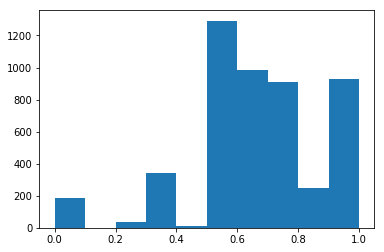

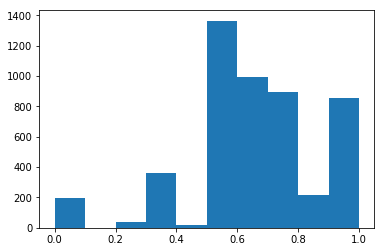

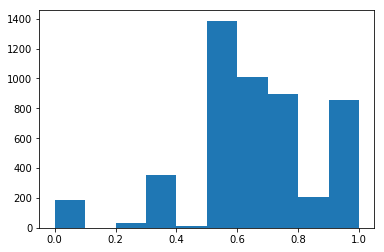

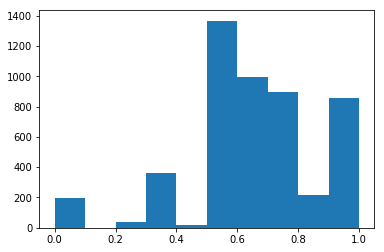

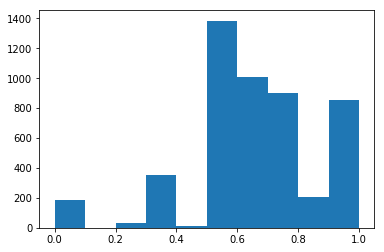

In [108]:
for i in range(num_blocks):
    plt.hist(blocks_graph_data[i])
    plt.savefig('Block_'+density_type+'_'+str(i+1))
    plt.show()